In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import math
import time 

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Numerical set up

In [2]:
# Parameters to be defined for different grid size and conductivity
dx = 1       # Grid size in x    
dy = 1       # Grid size in y       
dz = 5       # Grid size in z    
Dx = 100.0   # Conductivity in x    
Dy = 100.0   # Conductivity in y
Dz = 100.0   # Conductivity in z
n = 5        # aspect ratio of z to x and y ==> also means the number of cell at the final grid level 
             #                              ==> should be fine if below 20
# Parameters for the computational domain
alpha = 1    # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128     # Grid point in x
ny = 128     # Grid point in y
nz = nx*n     # Grid point in z

In [3]:
# the weights matrix
w1 = np.zeros([1,2,2,2,1])
w2 = np.zeros([1,3,3,3,1])
w1[0,:,:,:,0] = 0.125
pd1 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
pd2 = [[0.0, 1.0*Dy/dy**2,  0.0],
       [1.0*Dx/dx**2,  -(2*Dx/dx**2+2*Dy/dy**2+2*Dz/dz**2),  1.0*Dx/dx**2],
       [0.0, 1.0*Dy/dy**2,  0.0]]
pd3 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
w2[0,0,:,:,0] = -np.array(pd1) 
w2[0,1,:,:,0] = -np.array(pd2) 
w2[0,2,:,:,0] = -np.array(pd3) 

# Weights of layers

In [4]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)) )

# Jacobi matrix 

In [5]:
CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer)
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5), int(ny*0.5), int(nz*0.5), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**2), int(ny*0.5**2), int(nz*0.5**2), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**3), int(ny*0.5**3), int(nz*0.5**3), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**4), int(ny*0.5**4), int(nz*0.5**4), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**5), int(ny*0.5**5), int(nz*0.5**5), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**6), int(ny*0.5**6), int(nz*0.5**6), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**7), int(ny*0.5**7), int(nz*0.5**7), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

In [6]:
CNN3D_A_1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 1, 1, 5, 1)        28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


# Restriction matrix

In [7]:
CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
])    
CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5), int(ny*0.5), int(nz*0.5), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**2), int(ny*0.5**2), int(nz*0.5**2), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**3), int(ny*0.5**3), int(nz*0.5**3), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**4), int(ny*0.5**4), int(nz*0.5**4), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**5), int(ny*0.5**5), int(nz*0.5**5), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nx*0.5**6), int(ny*0.5**6), int(nz*0.5**6), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

In [8]:
CNN3D_res_2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 1, 1, 5, 1)        9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


# Prolongation matrix

In [9]:
CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1*n, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2*n, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4*n, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8*n, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16*n, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32*n, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64*n, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

In [10]:
CNN3D_prol_64.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d_6 (UpSampling3 (None, 128, 128, 640, 1)  0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


# Load data

In [11]:
T = np.zeros([nz,ny,nx])
for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+43][j+43][k+43] = 1 

In [12]:
input_shape = (1,nz,ny,nx,1)
values = tf.zeros(input_shape)
print('values.shape: ', values.shape)
values = tf.Variable(values)[0,:,:,:,0].assign(tf.Variable(values)[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))

values.shape:  (1, 640, 128, 128, 1)


# Functions for Boundary conditions

In [13]:
def boundary_condition_top(values):
    'Specify Neumann boundary condition at the top of domain'
    temp = tf.Variable(values)
    temp[0,0,:,:,0].assign(tf.Variable(values)[0,1,:,:,0]) 
    return temp


# Initial condition

Text(0.5, 1.0, 'central xy plane')

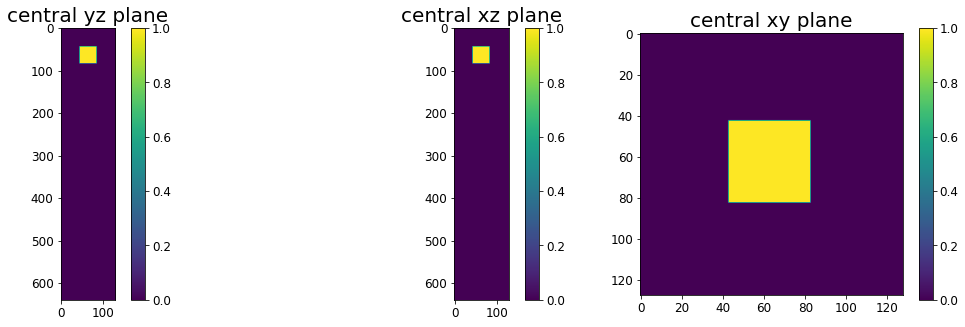

In [14]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,63,0])
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,63,:,0])
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,63,:,:,0])
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

# Multigrid network with skipping layer

In [15]:
start = time.time()
b = values           # only for one time step
multi_itr = 1000     # multigrid iteration
j_itr = 1            # jacobi iteration 
for multi_grid in range(multi_itr):    
    w = np.zeros([1,1,1,1,1])
# --------- Calculate Residual based on initial guess --------  
    r = CNN3D_A_128(values) - b 
# ------------------------------------------------------------  

# --------- Interpolate Residual from finer to coaser mesh --------  
    r_64 = CNN3D_res_128(r) 
    r_32 = CNN3D_res_64(r_64) 
    r_16 = CNN3D_res_32(r_32) 
    r_8 = CNN3D_res_16(r_16) 
    r_4 = CNN3D_res_8(r_8) 
    r_2 = CNN3D_res_4(r_4) 
    r1 = CNN3D_res_2(r_2)    
# -----------------------------------------------------------------      

# --------- Interpolate Residual from coaser to finer mesh --------  
    for Jacobi in range(j_itr):
        w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r1/w2[0,1,1,1,0]
    w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r1/w2[0,1,1,1,0]
    w_2 = CNN3D_prol_1(w)                   
    for Jacobi in range(j_itr):
        w_2 = w_2 - CNN3D_A_2(w_2)/w2[0,1,1,1,0] + r_2/w2[0,1,1,1,0]
    w_4 = CNN3D_prol_2(w_2) 
    for Jacobi in range(j_itr):
        w_4 = w_4 - CNN3D_A_4(w_4)/w2[0,1,1,1,0] + r_4/w2[0,1,1,1,0]
    w_8 = CNN3D_prol_4(w_4) 
    for Jacobi in range(j_itr):
        w_8 = w_8 - CNN3D_A_8(w_8)/w2[0,1,1,1,0] + r_8/w2[0,1,1,1,0]
    w_16 = CNN3D_prol_8(w_8) 
    for Jacobi in range(j_itr):
        w_16 = w_16 - CNN3D_A_16(w_16)/w2[0,1,1,1,0] + r_16/w2[0,1,1,1,0]
    w_32 = CNN3D_prol_16(w_16) 
    for Jacobi in range(j_itr):
        w_32 = w_32 - CNN3D_A_32(w_32)/w2[0,1,1,1,0] + r_32/w2[0,1,1,1,0]
    w_64 = CNN3D_prol_32(w_32)
    for Jacobi in range(j_itr):
        w_64 = w_64 - CNN3D_A_64(w_64)/w2[0,1,1,1,0] + r_64/w2[0,1,1,1,0]
    w_128 = CNN3D_prol_64(w_64)
    w_128 = w_128 - CNN3D_A_128(w_128)/w2[0,1,1,1,0] + r/w2[0,1,1,1,0]
# ----------------------------------------------------------------- 

# --------- Correct initial guess --------  
    values = values - w_128 
    values = values - CNN3D_A_128(values)/w2[0,1,1,1,0] + b/w2[0,1,1,1,0]
    values = boundary_condition_top(values)
# ----------------------------------------  
end = time.time()
print('Computational time(s):',(end-start))
print('Multigrid iterations:', multi_itr)
print('Jacobi iterations:', j_itr)

Computational time(s): 1548.2789223194122
Multigrid iterations: 1000
Jacobi iterations: 1


### Residual on 4 x 4 x 4 grid

Text(0.5, 1.0, 'central xy plane')

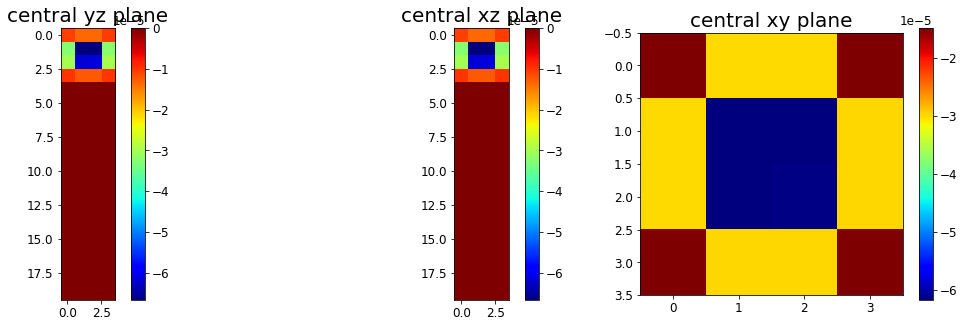

In [16]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_4[0,:,:,2,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_4[0,:,2,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_4[0,2,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on 8 x 8 x 8 grid

Text(0.5, 1.0, 'central xy plane')

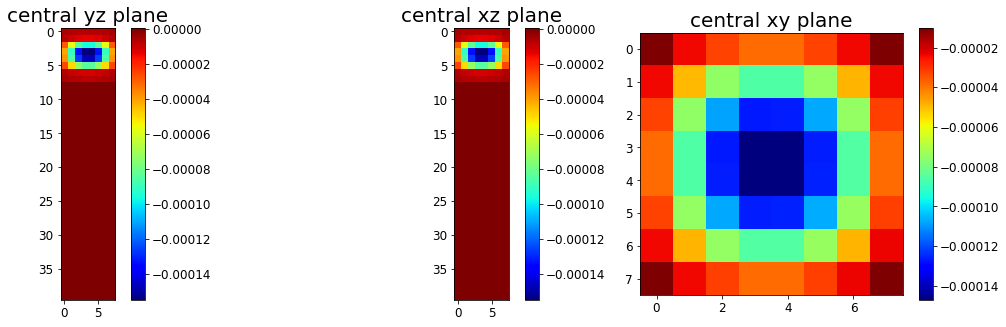

In [17]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_8[0,:,:,4,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_8[0,:,4,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_8[0,4,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on 16 x 16 x 16 grid

Text(0.5, 1.0, 'central xy plane')

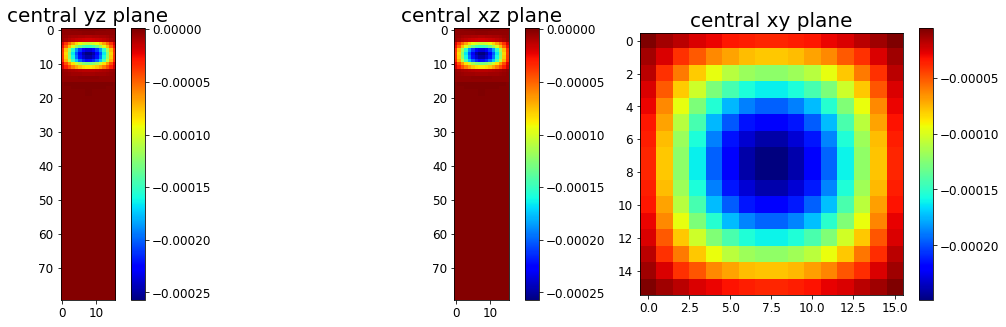

In [18]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_16[0,:,:,8,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_16[0,:,8,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_16[0,8,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on 32 x 32 x 32 grid

Text(0.5, 1.0, 'central xy plane')

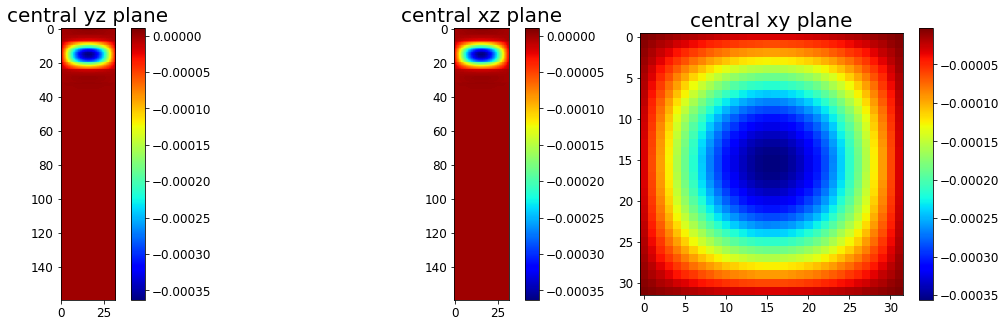

In [19]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_32[0,:,:,16,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_32[0,:,16,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_32[0,16,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on 64 x 64 x 64 grid

Text(0.5, 1.0, 'central xy plane')

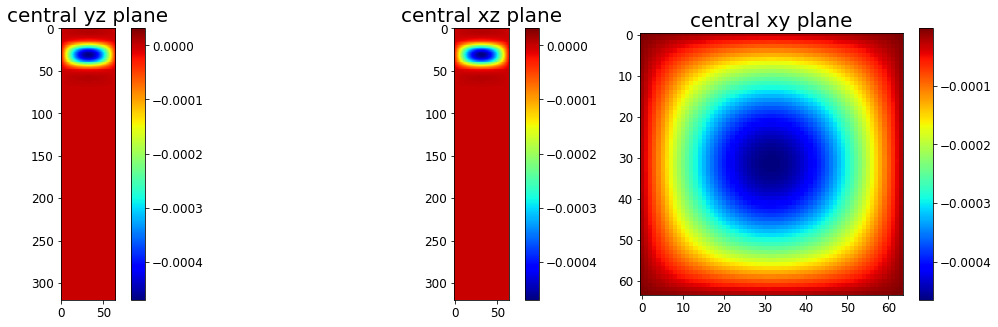

In [20]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_64[0,:,:,32,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_64[0,:,32,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_64[0,32,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on 128 x 128 x 128 grid

Text(0.5, 1.0, 'central xy plane')

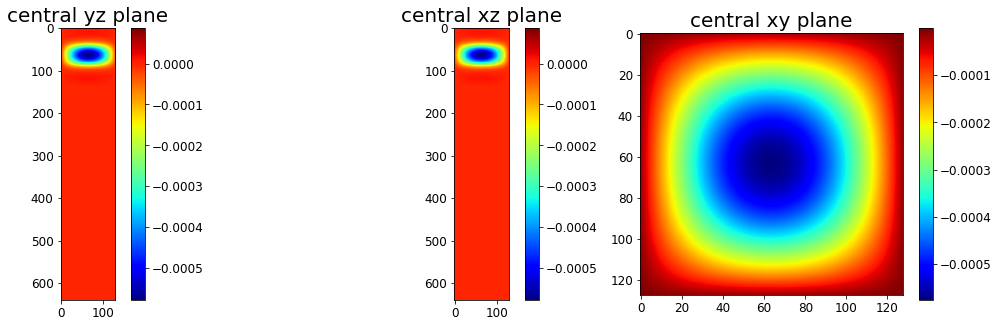

In [21]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_128[0,:,:,64,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_128[0,:,64,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_128[0,64,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Steady state results

Text(0.5, 1.0, 'central xy plane')

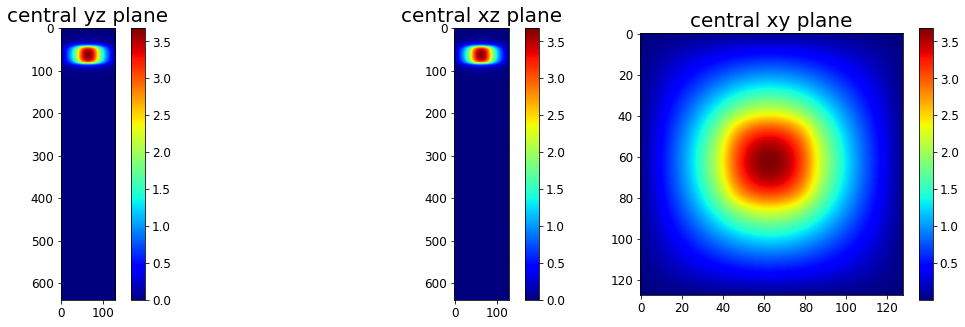

In [22]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,64,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,64,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,64,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)